<a href="https://colab.research.google.com/github/Joao-Maria-Janeiro/Pneumonia-Detection-Kaggle/blob/main/pneumonia_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:32<00:00, 51.9MB/s]
100% 2.29G/2.29G [00:32<00:00, 75.7MB/s]


In [7]:
! mkdir xray-pneumonia-dataset

In [ ]:
! unzip chest-xray-pneumonia.zip -d xray-pneumonia-dataset

In [9]:
!ls xray-pneumonia-dataset/chest_xray/chest_xray/

test  train  val


In [10]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

In [11]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_CHANNELS=3
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
BATCH_SIZE = 6
EPOCHS = 15

# Root path
ROOT_PATH = "xray-pneumonia-dataset/chest_xray/chest_xray/"

# 'train' path
TRAIN = ROOT_PATH + 'train/'

# 'test' path
TEST = ROOT_PATH + 'test/'

# 'validation' path
VAL = ROOT_PATH + 'VAL/'
VAL_NORMAL = ROOT_PATH + "val/NORMAL/"
VAL_SICK = ROOT_PATH + "val/PNEUMONIA/"

In [12]:
# Creating 'labels'

label_names = ['NORMAL', 'PNEUMONIA']
label_names_ = {label_names:i for i, label_names in enumerate(label_names)}
label_names_

{'NORMAL': 0, 'PNEUMONIA': 1}

In [13]:
import cv2
from skimage import io

def load_data():
    
    datasets = [TRAIN,
               TEST]
    
    output = []
    
    for dataset in datasets:
        print("Loading:", dataset)
        
        images = []
        labels = []
        
        for folder in os.listdir(dataset):
            
            if folder != '.DS_Store':


                print("Folder:", folder)
                label = label_names_[folder]

                for file in os.listdir(dataset + '/' + folder):


                        try:

                            img_path = dataset + '/' + folder + '/' + file

                            image = cv2.imread(img_path)
                            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                            image = cv2.resize(image, IMAGE_SIZE)

                            images.append(image)
                            labels.append(label)



                        except Exception as e:
                            print(e, file)
                
            else:
                continue
               
                
        images = np.array(images, dtype='float32')
        labels = np.array(labels, dtype='int32')
        
        output.append((images, labels))
        
    return output                                   

In [14]:
# Reading images: 'train' and 'test' 

(X_train, y_train), (X_test, y_test) = load_data()

Loading: xray-pneumonia-dataset/chest_xray/chest_xray/train/
Folder: NORMAL
OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
 .DS_Store
Folder: PNEUMONIA
OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
 .DS_Store
Loading: xray-pneumonia-dataset/chest_xray/chest_xray/test/
Folder: NORMAL
Folder: PNEUMONIA


In [15]:
from sklearn.utils import shuffle           

X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [16]:
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (5216, 128, 128, 3)
y_train: (5216,)
X_test: (624, 128, 128, 3)
y_test: (624,)


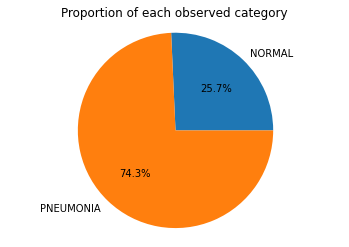

In [17]:
_, train_counts = np.unique(y_train, return_counts=True)
_, test_counts = np.unique(y_test, return_counts=True)

plt.pie(train_counts,
        explode=(0, 0) , 
        labels=label_names,
        autopct='%1.1f%%')

plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [18]:
# Reading 'validation' images 

from skimage.io import imread
import cv2


def read_data(path, category):
    X = []
    Y = []
    
    for file in os.listdir(path):

        if file != '.DS_Store':

            try:

                image = cv2.imread(path + file)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)

                X.append(image)

                Y.append(label_names_[category])

            except Exception as e:
                    print(e, file)
                    
        else:
            continue
    
    return np.array(X), np.array(Y)


In [19]:
X_val1, y_val1 = read_data(VAL_NORMAL, 'NORMAL')
X_val2, y_val2 = read_data(VAL_SICK, 'PNEUMONIA')

print(X_val1.shape)
print(y_val1.shape)
print(X_val2.shape)
print(y_val2.shape)

# Concatenating

X_val = [X_val1, X_val2]
X_val = np.concatenate(X_val)

y_val = [y_val1, y_val2]
y_val = np.concatenate(y_val)

print("Shape final 'X_val':", X_val.shape)
print("Shape final 'y_val':", y_val.shape)

(8, 128, 128, 3)
(8,)
(8, 128, 128, 3)
(8,)
Shape final 'X_val': (16, 128, 128, 3)
Shape final 'y_val': (16,)


In [20]:
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

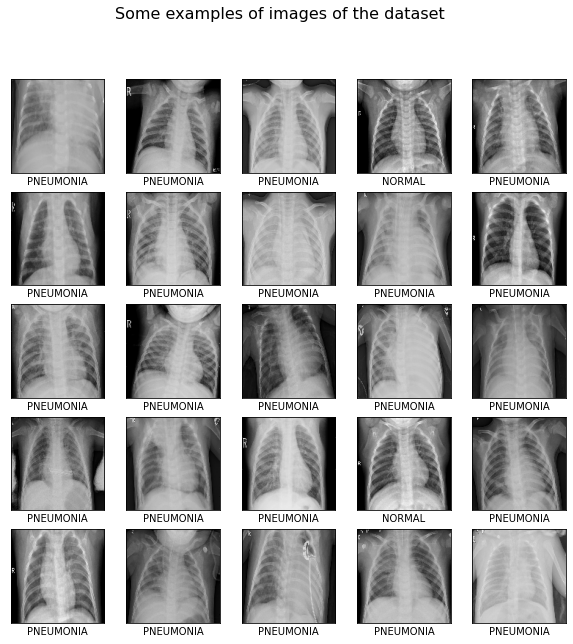

In [21]:
def display_random_images (class_names, images, labels):    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[255+i], cmap=plt.cm.binary)
        plt.xlabel(label_names[labels[255+i]])
    plt.show()
    
display_random_images(label_names, X_train, y_train)

In [44]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.layers import Dense, Dropout, Reshape, GlobalAveragePooling2D, Flatten
from keras.applications.vgg16 import VGG16
from keras.regularizers import l2

In [23]:
#Amplifying the dataset with the data generator

datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range = 50,  
        zoom_range = 1,  
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip = True,  
        vertical_flip=False) 

validation_datagen = ImageDataGenerator()

datagen.fit(X_train)

# Training the model

## With transfer learning

In [58]:
base_model = VGG19(weights = 'imagenet', include_top = False,input_shape=(128,128,3))

for layer in base_model.layers:
      layer.trainable = True

model = tf.keras.Sequential([
    Reshape((128,128,3)),
    base_model,
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer = 'l2'),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer = 'l2'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss = "binary_crossentropy", optimizer = 'adam', metrics=['accuracy'])

In [59]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [60]:
history = model.fit(datagen.flow(X_train,y_train, batch_size = 32) ,epochs = 25, 
                           validation_data = validation_datagen.flow(X_val, y_val))

Epoch 1/25
163/163 [==============================] - 30s 173ms/step - loss: 2.9014 - accuracy: 0.7255 - val_loss: 1.0499 - val_accuracy: 0.5000
Epoch 2/25
163/163 [==============================] - 28s 170ms/step - loss: 0.8273 - accuracy: 0.7383 - val_loss: 0.9275 - val_accuracy: 0.5000
Epoch 3/25
163/163 [==============================] - 28s 171ms/step - loss: 0.6464 - accuracy: 0.7389 - val_loss: 0.7639 - val_accuracy: 0.5000
Epoch 4/25
163/163 [==============================] - 28s 171ms/step - loss: 0.5754 - accuracy: 0.7362 - val_loss: 0.8384 - val_accuracy: 0.5000
Epoch 5/25
163/163 [==============================] - 28s 170ms/step - loss: 0.5779 - accuracy: 0.7510 - val_loss: 0.8189 - val_accuracy: 0.5000
Epoch 6/25
163/163 [==============================] - 28s 170ms/step - loss: 0.5823 - accuracy: 0.7381 - val_loss: 0.8144 - val_accuracy: 0.5000
Epoch 7/25
163/163 [==============================] - 28s 171ms/step - loss: 0.5607 - accuracy: 0.7560 - val_loss: 0.8054 - val_ac

In [61]:
model.evaluate(X_test, y_test)

20/20 [==============================] - 1s 50ms/step - loss: 0.6998 - accuracy: 0.6250


[0.6997717618942261, 0.625]

In [62]:
model.evaluate(X_train, y_train)

163/163 [==============================] - 8s 50ms/step - loss: 0.5701 - accuracy: 0.7429


[0.5701355934143066, 0.7429064512252808]

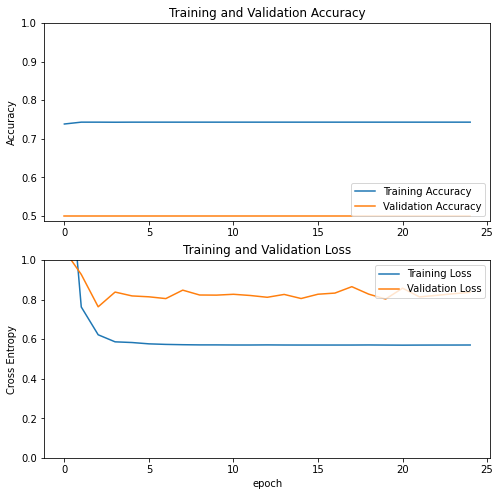

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Without transfer learning

In [ ]:
model_seq = tf.keras.Sequential([
    tf.keras.Input((128, 128, 3)),
    tf.keras.layers.Conv2D(512, (3, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(256, (3, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(128, (3, 3), padding = 'same'),
    tf.keras.layers.Conv2D(64, (3, 3), padding = 'valid'),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model_seq.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 126, 126, 512)     14336     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 42, 42, 512)       0         
_________________________________________________________________
re_lu_21 (ReLU)              (None, 42, 42, 512)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 40, 40, 256)       1179904   
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 13, 13, 256)       0         
_________________________________________________________________
re_lu_22 (ReLU)              (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 13, 13, 128)      

In [ ]:
model_seq.compile(loss = "binary_crossentropy", optimizer = 'adam', metrics=['accuracy'])

In [ ]:
history = model_seq.fit(datagen.flow(X_train,y_train, batch_size = 32) ,epochs = 30, 
                           validation_data = validation_datagen.flow(X_val, y_val))

Epoch 1/30
163/163 [==============================] - 24s 146ms/step - loss: 0.2930 - accuracy: 0.8715 - val_loss: 0.6592 - val_accuracy: 0.6875
Epoch 2/30
163/163 [==============================] - 23s 142ms/step - loss: 0.2796 - accuracy: 0.8865 - val_loss: 1.2645 - val_accuracy: 0.5625
Epoch 3/30
163/163 [==============================] - 23s 143ms/step - loss: 0.2766 - accuracy: 0.8859 - val_loss: 0.9551 - val_accuracy: 0.6250
Epoch 4/30
163/163 [==============================] - 23s 142ms/step - loss: 0.2745 - accuracy: 0.8867 - val_loss: 1.2164 - val_accuracy: 0.5625
Epoch 5/30
163/163 [==============================] - 23s 142ms/step - loss: 0.2824 - accuracy: 0.8825 - val_loss: 0.9246 - val_accuracy: 0.6250
Epoch 6/30
163/163 [==============================] - 23s 142ms/step - loss: 0.2798 - accuracy: 0.8882 - val_loss: 1.2290 - val_accuracy: 0.5625
Epoch 7/30
163/163 [==============================] - 23s 143ms/step - loss: 0.2745 - accuracy: 0.8848 - val_loss: 0.8425 - val_ac

In [ ]:
model_seq.evaluate(X_test, y_test)

20/20 [==============================] - 1s 40ms/step - loss: 0.3731 - accuracy: 0.8702


[0.37312743067741394, 0.870192289352417]

In [ ]:
model_seq.evaluate(X_train, y_train)

163/163 [==============================] - 7s 41ms/step - loss: 0.1777 - accuracy: 0.9304


[0.17766888439655304, 0.9304064512252808]

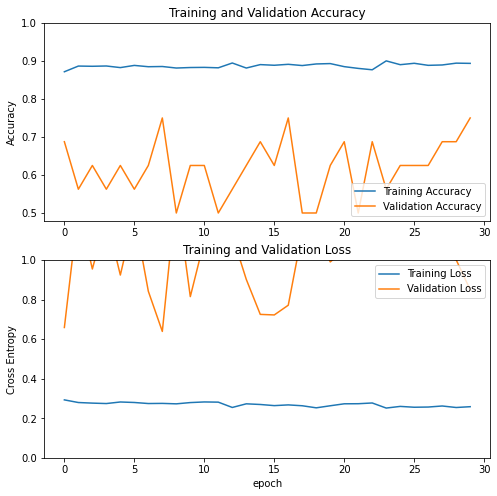

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()